In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sn
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

In [79]:
class YourModel(nn.Module):
    def __init__(self):
        super(YourModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        nn.init.xavier_normal_(self.layer1[0].weight)
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        nn.init.xavier_normal_(self.layer2[0].weight)
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        nn.init.xavier_normal_(self.layer3[0].weight)
        self.layer4 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        nn.init.xavier_normal_(self.layer4[0].weight)
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        nn.init.xavier_normal_(self.layer5[0].weight)
        self.layer6 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        nn.init.xavier_normal_(self.layer6[0].weight)
        
        self.layer7 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        nn.init.xavier_normal_(self.layer7[0].weight)
        self.layer8 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        nn.init.xavier_normal_(self.layer8[0].weight)
        
        self.layer9 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        nn.init.xavier_normal_(self.layer9[0].weight)
        self.layer10 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        nn.init.xavier_normal_(self.layer10[0].weight)
        
        self.dr1 = nn.Dropout(p = 0.25)
        self.fc1 = nn.Linear(7 * 7 * 256, 2048)
        nn.init.xavier_normal_(self.fc1.weight)
        self.dr2 = nn.Dropout(p = 0.25)
        self.fc2 = nn.Linear(2048, 256)
        nn.init.xavier_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = out.reshape(out.size(0), -1) # flatten layer
        out = self.dr1(out)
        out = self.fc1(out)
        out = self.dr2(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

model = YourModel()

In [80]:
batch_size = 64
n_epochs = 20

is_cpu_available = torch.cuda.is_available()

#optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.0003, momentum=0.95, weight_decay=0.0001)
criteria = nn.CrossEntropyLoss()

In [81]:
train_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(90),
            transforms.ColorJitter(brightness=0.75, contrast=0.75, saturation=0.75),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
val_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
test_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

train_dataset = ImageFolder('./dataset1_/train', train_transforms)
val_dataset = ImageFolder('./dataset1_/val', val_transforms)
test_dataset = ImageFolder('./dataset1_/test', test_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=32, num_workers=4, shuffle=False)
val_loader = DataLoader(dataset=test_dataset, batch_size=32, num_workers=4, shuffle=False)

In [82]:
model.train()

if is_cpu_available:
    model.cuda()
    criteria.cuda()

losses_epoch_train = []
accuracy_epoch_train = []

losses_epoch_val = []
accuracy_epoch_val = []

writer = SummaryWriter()

# Training loop
for epoch in range(n_epochs):
    total = 0
    epoch_loss = 0
    epoch_correct = 0
    for ix, data in enumerate(train_loader):
        model.zero_grad()
        
        img, label = data
        if is_cpu_available:
            img = img.cuda()
            label = label.cuda()

        # Forward pass
        outputs = model.forward(img)
        loss = criteria(outputs, label)

        # Prevent gradient addition
        optimizer.zero_grad()

        # Gradient calculation
        loss.backward()

        # Optimization
        optimizer.step()

        # Train loss for iter
        epoch_loss += loss.item()

        # Train accuracy for iter
        _, predictions = torch.max(outputs.data, 1)
        correct_pediction = (predictions == label).sum()

        epoch_correct += correct_pediction
        total += len(label)
        
    losses_epoch_train.append(epoch_loss / len(train_loader))
    accuracy_epoch_train.append(epoch_correct / total)

    writer.add_scalars('loss', {'train loss': epoch_loss / len(train_loader)}, epoch)
    writer.add_scalars('acc', {'train acc': epoch_correct / total}, epoch)
    
    print('Epoch: {} - Train Loss: {} - Train Accuracy: {}'.format(epoch, epoch_loss / len(train_loader), epoch_correct / total))          

    with torch.no_grad():
        model.eval()

        total = 0
        epoch_loss = 0
        epoch_correct = 0
        # Measure the performance in validation set.
        for ix, data in enumerate(val_loader):
            img, label = data

            if is_cpu_available:
                img = img.cuda()
                label = label.cuda()

            # Test forward
            outputs = model.forward(img)
            loss = criteria(outputs, label)

            # Test loss for iter
            epoch_loss += loss.item()

            # Train accuracy for iter
            _, predictions = torch.max(outputs.data, 1)
            correct_pediction = (predictions == label).sum()

            epoch_correct += correct_pediction
            total += len(label)
            
        losses_epoch_val.append(epoch_loss / len(val_loader))
        accuracy_epoch_val.append(epoch_correct / total)

        writer.add_scalars('loss', {'val loss': epoch_loss / len(val_loader)}, epoch)
        writer.add_scalars('acc', {'val acc': epoch_correct / total}, epoch)

        print('Epoch: {} - Val Loss: {} - Val Accuracy: {}'.format(epoch, epoch_loss / len(val_loader), epoch_correct / total))          

    model.train()
    
writer.close()

Epoch: 0 - Train Loss: 1.737380862236023 - Train Accuracy: 0.37181633710861206
Epoch: 0 - Val Loss: 1.392825844217441 - Val Accuracy: 0.4367130696773529
Epoch: 1 - Train Loss: 1.0902550164391012 - Train Accuracy: 0.6055029034614563
Epoch: 1 - Val Loss: 1.5185395915880993 - Val Accuracy: 0.4784625768661499
Epoch: 2 - Train Loss: 0.8687022454598371 - Train Accuracy: 0.6793084740638733
Epoch: 2 - Val Loss: 1.5213046662320266 - Val Accuracy: 0.5838303565979004
Epoch: 3 - Train Loss: 0.6993657837895786 - Train Accuracy: 0.742331326007843
Epoch: 3 - Val Loss: 1.3311356280088755 - Val Accuracy: 0.5937707424163818
Epoch: 4 - Train Loss: 0.6875118199516745 - Train Accuracy: 0.7540435194969177
Epoch: 4 - Val Loss: 1.3515057192962558 - Val Accuracy: 0.5884692072868347
Epoch: 5 - Train Loss: 0.5309305061312283 - Train Accuracy: 0.8111173510551453
Epoch: 5 - Val Loss: 1.560562519879871 - Val Accuracy: 0.5407555103302002
Epoch: 6 - Train Loss: 0.4628127682734938 - Train Accuracy: 0.8271054625511169


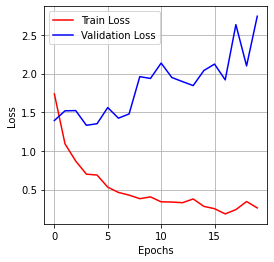

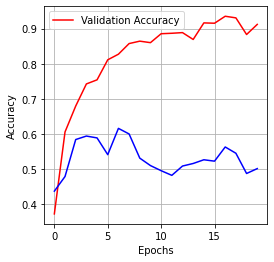

In [83]:
fig, ax = plt.subplots(figsize=(4, 4))
plt.plot(losses_epoch_train , color='r')
plt.plot(losses_epoch_val, color='b')
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax.grid(True)

fig, ax = plt.subplots(figsize=(4, 4))
plt.plot(accuracy_epoch_train , color='r')
plt.plot(accuracy_epoch_val, color='b')
plt.legend(["Validation Accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
ax.grid(True)

Test Accuracy: % 0.5786470770835876 


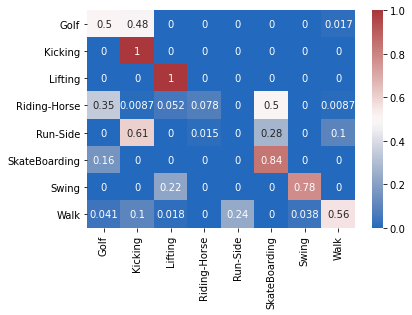

In [84]:
from sklearn.metrics import confusion_matrix

model.eval()

targets = []
predicts = []
labs = ['Golf', 'Kicking', 'Lifting', 'Riding-Horse', 'Run-Side', 'SkateBoarding', 'Swing', 'Walk']

with torch.no_grad():
    total = 0
    correct_prediction = 0
    for data in test_loader:
        img, label = data
        
        if is_cpu_available:
            img = img.cuda()
            label = label.cuda()
        
        outputs = model.forward(img)

        _, predictions = torch.max(outputs.data, 1)
        correct_prediction += (predictions == label).sum()
        
        total += len(label)
        
        preds = predictions.detach().cpu().numpy()
        labels = label.detach().cpu().numpy()
        
        for i in range(len(preds)):
            targets.append(labels[i])
            predicts.append(preds[i])

    print('Test Accuracy: % {} '.format(correct_prediction / total))
    
    matrix = confusion_matrix(targets, predicts, normalize = 'true')
    sn.heatmap(matrix, annot=True, cmap = sn.color_palette("vlag", as_cmap=True), xticklabels=labs, yticklabels=labs)